### Generating human faces with Adversarial Networks (5 points)
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>
This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over the Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on https://github.com/Lasagne/Recipes/pull/94 .

In [1]:
import numpy as np


from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({'axes.titlesize': 'small'})


import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid
from torch.autograd import Variable


device = torch.device("cuda")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls drive/MyDrive/celeba_data

identity_CelebA.txt   list_bbox_celeba.txt     list_landmarks_align_celeba.txt
list_attr_celeba.txt  list_eval_partition.txt  list_landmarks_celeba.txt


In [4]:
!mkdir celeba
!cp drive/MyDrive/celeba_data/* celeba
!cp -R drive/MyDrive/CelebA/Img/img_align_celeba.zip ./celeba

In [5]:
!ls celeba

identity_CelebA.txt   list_eval_partition.txt
img_align_celeba.zip  list_landmarks_align_celeba.txt
list_attr_celeba.txt  list_landmarks_celeba.txt
list_bbox_celeba.txt


In [6]:
!cd celeba && unzip -q img_align_celeba.zip && cd ..

In [7]:
#drive.flush_and_unmount()

In [8]:
#!L
class CropCelebA64:
    
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [9]:


#!L

# Note that for simplicity we reduce the number of channels to 1
# But if you want to be hardcore feel free to comment .Grayscale :)

train_dataset = torchvision.datasets.CelebA(
    root='.',
    split='train',
    #download=True,
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(0.5, 0.5)
    ]),
)

In [10]:
IMG_SHAPE = tuple(train_dataset[0][0].shape)
assert IMG_SHAPE[1] == IMG_SHAPE[2]
DIM = IMG_SHAPE[1]

In [11]:
IMG_SHAPE

(3, 64, 64)

### Prepare Dataset

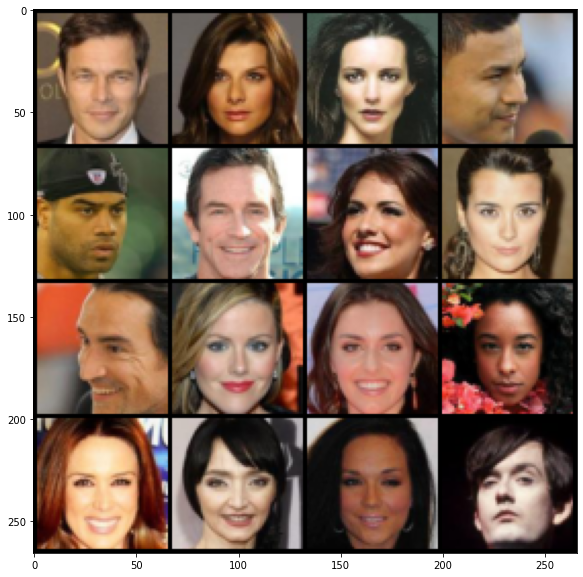

In [12]:
#!L
# print some images
samples = torch.stack([train_dataset[i][0] for i in range(32, 48)], dim=0)

plt.figure(figsize=(10, 10))
plt.imshow(make_grid((1 + samples) / 2, nrow=4).permute(1, 2, 0))
plt.show()

max# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it? 
* build some network that generates a face (small image)
* make up a __measure__ of __how good this face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [13]:
MAX_VAL = 1e5;

def is_valid(tensor):
    pass
    #assert torch.sum(tensor.isnan()) == 0
    #assert torch.sum(torch.logical_or(tensor > MAX_VAL, tensor < -MAX_VAL)) == 0

In [14]:
#!L
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE)
    return noise.to(device)
    
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape = shape
    
    def forward(self,input):
        return input.view(self.shape)

In [34]:
#!L
CODE_SIZE = 100 # Size of z noise vector; feel free to change it


class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()

        # TODO

        self.generator = nn.Sequential(
            nn.Linear(CODE_SIZE, 512 *8*8),
            Reshape([-1, 512, 8, 8]),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),

            nn.Conv2d(512, 512, kernel_size=3, padding='same', padding_mode='reflect', bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),


            nn.PixelShuffle(2),
            nn.Conv2d(128, 128, kernel_size=3, padding='same', padding_mode='reflect', bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.Conv2d(128, 128, kernel_size=3, padding='same', padding_mode='reflect', bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.PixelShuffle(2),
            nn.Conv2d(32, 32, kernel_size=3, padding='same', padding_mode='reflect', bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            nn.Conv2d(32, 32, kernel_size=3, padding='same', padding_mode='reflect', bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            nn.PixelShuffle(2),
            nn.Conv2d(8, 3, kernel_size=3, padding='same', padding_mode='reflect', bias=False),
            nn.BatchNorm2d(3),
            nn.LeakyReLU(),


            nn.Conv2d(3, 3, kernel_size=3, padding='same', padding_mode='reflect', bias=False),
            nn.BatchNorm2d(3),
            nn.Tanh()
        )


    def forward(self, noise):
        return self.generator(noise)

generator = Generator().to(device)

In [35]:
noise = sample_noise_batch(100)
noise.shape

torch.Size([100, 100])

In [36]:
#!L
generated_data = generator(noise)
assert tuple(generated_data.shape)[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE, tuple(generated_data.shape)[1:])

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [37]:
#!L
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(len(train_dataset)), size=batch_size)
    batch = torch.stack([train_dataset[idx][0] for idx in idxs], dim=0)
    return batch.to(device)

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

In [38]:
#!L
class Discriminator3x64x64(nn.Module):
    def __init__(self):
        super(Discriminator3x64x64, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),


            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),


            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, padding=0),
        )

    def forward(self, x):
        x = self.model(x)
        return x

discriminator = Discriminator3x64x64().to(device)

In [39]:
#!L
images = sample_data_batch(4)

In [40]:
predictions = discriminator(images)

In [41]:
predictions.shape

torch.Size([4, 1, 1, 1])

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [42]:
#!L
def generator_loss(generator, discriminator, noise):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    generated_data = generator(noise)
    is_valid(generated_data)

    
    disc_on_fake_data = discriminator(generated_data)
    is_valid(disc_on_fake_data)

    return -disc_on_fake_data.mean()

In [43]:
#!L
loss = generator_loss(generator, discriminator, sample_noise_batch(32))

print(loss)

assert len(loss.shape) == 0, "Loss must be scalar"

tensor(0.1823, device='cuda:0', grad_fn=<NegBackward0>)


In [44]:
#!L
def discriminator_loss(discriminator, real_data, generated_data):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """

    disc_on_real_data = discriminator(real_data)
    disc_on_fake_data = discriminator(generated_data)
    
    is_valid(disc_on_real_data)
    is_valid(disc_on_fake_data)

    return disc_on_fake_data.mean() - disc_on_real_data.mean()

In [45]:
#!L
loss = discriminator_loss(discriminator, 
                    sample_data_batch(32), 
                   generator(sample_noise_batch(32)))

print(loss)

assert len(loss.shape) == 0, "Loss must be scalar"

tensor(0.2165, device='cuda:0', grad_fn=<SubBackward0>)


In [46]:
def grad_penalty_loss(discriminator, real_data, fake_data, alpha=None):
    if alpha is None:
        alpha = torch.rand((real_data.size(0), 1, 1, 1), device=device)
    mixed_data = alpha * real_data + (1 - alpha) * fake_data
    mixed_data.requires_grad_(True)
    mixed_prediction = discriminator(mixed_data)
    grads = torch.autograd.grad(
        inputs=mixed_data, 
        outputs=mixed_prediction, 
        create_graph=True, 
        retain_graph=True,
        grad_outputs=torch.ones_like(mixed_prediction)
    )[0]
    grads = grads.view(real_data.size(0), -1)
    return torch.mean((torch.linalg.norm(grads, dim=1) - 1) ** 2)

In [47]:
real_data = sample_data_batch(32)
fake_data = generator(sample_noise_batch(32))
alpha = torch.rand((real_data.size(0), 1, 1, 1), device=device)

In [48]:
#!L
loss = grad_penalty_loss(discriminator, 
                    real_data, 
                   fake_data, alpha)

print(loss)

assert len(loss.shape) == 0, "Loss must be scalar"

tensor(1.5615, device='cuda:0', grad_fn=<MeanBackward0>)


### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [55]:
#!L
def sample_images(generator, nrow, ncol, sharp=False, noise=None):
    with torch.no_grad():
        if noise is None:
            noise = sample_noise_batch(batch_size=nrow*ncol)
        else:
            assert noise.size(0) == nrow*ncol
        images = generator(noise)
        images = images.permute(0, 2, 3, 1).data.cpu().numpy()
        images = (1 + images) / 2
    if np.var(images)!=0:
        images = images.clip(0, 1)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i], interpolation="none")
        else:
            plt.imshow(images[i])
    plt.show()

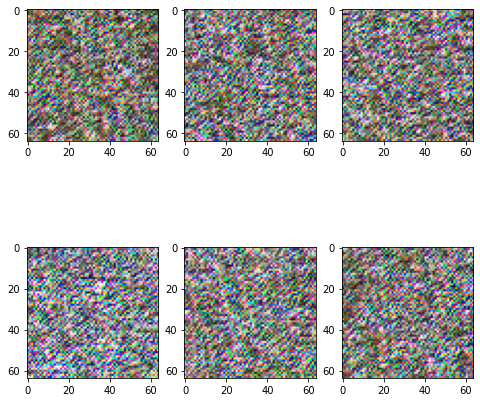

In [50]:
sample_images(generator, 2,3)

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

In [51]:
#!L
# optimizers
history_w_loss = []
history_gen_loss = []
total_iteration = 0
fixed_noise = sample_noise_batch(3*3)

epoch 4
Prev epoch taken 415.9117 seconds
iteration 200 out of 635
Disc W loss = -1.5553
Disc loss = -1.366
Gen loss = 0.7856


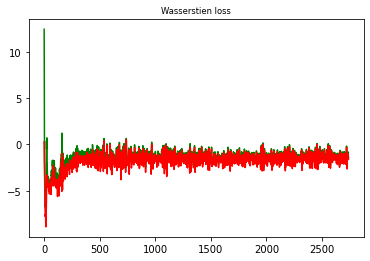

Fixed generated images


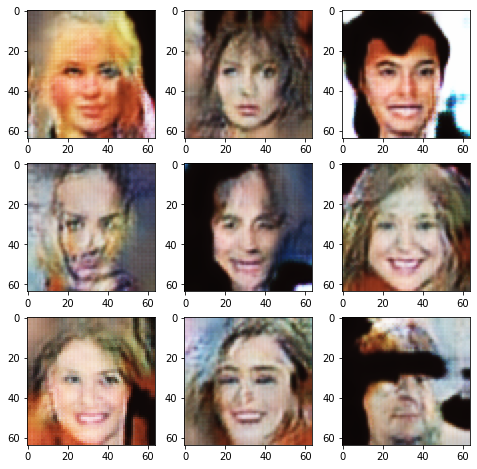

KeyboardInterrupt: ignored

In [52]:
#!L
from IPython import display
from tqdm.auto import tqdm
import time

batch_size = 256
lambda_gp = 10
ratio = 1

batches_per_epoch = len(train_dataset) // batch_size

loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))


prev_epoch_time = None


def get(lst, ind):
    return list(map(lambda x: x[ind], lst))

for epoch in range(25):
    start_time = time.perf_counter()
    for iteration, (batch, _) in tqdm(enumerate(loader)):
        discriminator.train()
        generator.train()
        # Train discriminator
        real_data = batch.to(device)
        fake_data = generator(sample_noise_batch(batch_size))
        d_loss = discriminator_loss(discriminator, real_data, fake_data)
        loss = d_loss + lambda_gp * grad_penalty_loss(discriminator, real_data, fake_data)
        disc_opt.zero_grad(set_to_none=True)
        loss.backward()
        disc_opt.step()
        
        history_w_loss.append((total_iteration, d_loss.cpu().data.numpy()))

        # Train generator
        if iteration % ratio == 0:
            noise = sample_noise_batch(batch_size)
            gen_loss = generator_loss(generator, discriminator, noise)
            gen_opt.zero_grad(set_to_none=True)
            gen_loss.backward()
            gen_opt.step()

            history_gen_loss.append((total_iteration, loss.cpu().data.numpy()))

        if iteration % 100 == 0:
            display.clear_output(wait=True)
            
            print("epoch {}".format(epoch))
            if prev_epoch_time:
                print(f"Prev epoch taken {prev_epoch_time:0.4f} seconds")
            print("iteration {} out of {}".format(iteration, len(train_dataset) // batch_size))
            print(f"Disc W loss = {d_loss:0.4f}")
            print(f"Disc loss = {loss:0.4}")
            print(f"Gen loss = {gen_loss:0.4}")

            plt.title('Wasserstien loss')
            plt.plot(get(history_gen_loss, 0), get(history_gen_loss, 1), color='green', label='gen')
            plt.plot(get(history_w_loss, 0), get(history_w_loss, 1), color='red', label='discr')
            plt.show()

            print("Fixed generated images")
            sample_images(generator, 3,3, noise=fixed_noise)
            #sample_probas(generator, discriminator, 1000)
        total_iteration += 1
    prev_epoch_time = time.perf_counter() - start_time
    
    
print(f"Last epoch taken {prev_epoch_time:0.4f} seconds")

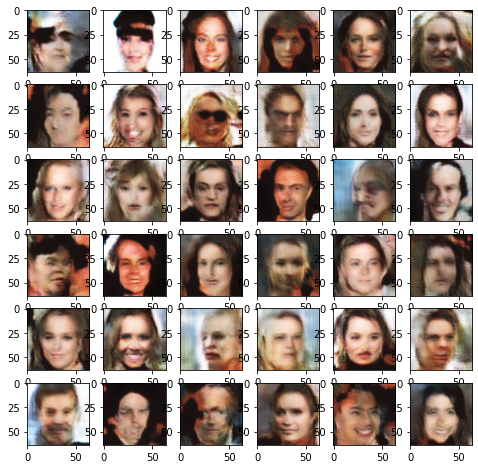

In [56]:
#!L
sample_images(generator, 6, 6)

# Note: a no-nonsense neural network should be able to produce reasonably good images after 15k iterations
# By "reasonably good" we mean "resembling a car crash victim" or better

## Future work
### Calculate FID
Calc FID each epoch, plot progress, compare with SOTA

### StyleGan-1
Link https://paperswithcode.com/method/stylegan

Features:
1. Separate noise for each scale
2. Preprocess noise by scaling before adding
3. AdaIN blocks
4. Add Style with dense net preprocessing
5. Style mixing - using two style latents

### Miscelanous
* Try ratio = 3 or 5
* Residual blocks
* Dropout in D
* Train D on labels
* R1 regularization https://paperswithcode.com/method/r1-regularization
* BEGAN
* SAGAN
* Spectral normalization


In [ ]:
!pip install pytorch-ignite

In [ ]:
from ignite.metrics import FID



m = FID()


torch.manual_seed(0)
y_pred, y = torch.rand(100, 3, 299, 299), torch.rand(100, 3, 299, 299)
for i in tqdm.tqdm(range(len(y_pred))):
    torchvision.utils.save_image(y_pred[i], f'pred/{i}.png')
    torchvision.utils.save_image(y[i], f'gt/{i}.png')
    m.update((y_pred[i:i+1], y[i:i+1]))

print('ignite online FID', m.compute())  # 6.109078042628951

### Evaluation
__The code below__ dumps a batch of images so that you could use them for precision/recall evaluation.

Please generate the same number of images as for autoencoders for a fair comparison.

In [ ]:
#!L
num_images = 10000
batch_size = 100

all_images = []

for batch_i in range(int((num_images - 1) / batch_size + 1)):
    with torch.no_grad():
        images = generator(sample_noise_batch(batch_size=batch_size))
        images = images.data.cpu().numpy().transpose([0, 2, 3, 1])
    if np.var(images)!=0:
        images = images.clip(0, 1)
        
    all_images.append(images)
    
all_images = np.concatenate(all_images, axis=0)[:num_images]

np.savez("./gan.npz", Pictures=all_images)